In [2]:
import tensorflow as tf
import numpy as np
import sys
import os
import pandas as pd

from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import Image

from tqdm import tqdm as tqdm
from PIL import Image

In [4]:
def create_dir(path):
    if(not os.path.isdir(path)):
        print('Creating Directory At {}...'.format(path))
        os.mkdir(path)

In [5]:
bathroom_path = './data/bathroom/'
bedroom_path = './data/bedroom/'
exterior_path = './data/exterior/'
food_path ='./data/food/'
gym_path ='./data/gym/'

im_list=[bathroom_path,bedroom_path,exterior_path,food_path,gym_path]

In [6]:
for i in im_list :
    create_dir(i)

Creating Directory At ./data/bathroom/...
Creating Directory At ./data/bedroom/...
Creating Directory At ./data/exterior/...
Creating Directory At ./data/food/...
Creating Directory At ./data/gym/...


In [7]:
import urllib.request
from PIL import Image

In [8]:
#load csv data
bathroom = pd.read_csv('bathroom.csv')
bedroom = pd.read_csv('bedroom.csv')
exterior = pd.read_csv('exterior.csv')
food = pd.read_csv('food.csv')
gym = pd.read_csv('gym.csv')

In [3]:
def setup_dat(dat,types,path,total):
    typ=types
    
    for i in tqdm(range(total)):
        urllib.request.urlretrieve(dat['raw_image_url'].loc[i],f"{path}/{typ}_{i}.png")

In [17]:
size=300

In [18]:
setup_dat(bathroom,'bath',bathroom_path,size);
setup_dat(bedroom,'bedroom',bedroom_path,size);
setup_dat(exterior,'exterior',exterior_path,size);
setup_dat(food,'food',food_path,size);
setup_dat(gym,'gym',gym_path,size);

100%|██████████| 300/300 [00:34<00:00,  8.59it/s]


## split file

In [25]:
import splitfolders 

splitfolders.ratio('./data', output="./data", seed=7, ratio=(0.8,0.1,0.1), group_prefix=None, move=True)

Copying files: 1500 files [00:00, 20395.95 files/s]


In [17]:
# Define Input Parameters
dim = (224, 224)
channel = (3,)
input_shape = dim + channel

batch_size = 10

# Data Generator

In [4]:
# Create Image Generator
def create_new_generator(path, dim, batch_size):
    datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    generator = datagen.flow_from_directory(
        path,
        target_size=dim,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    
    return generator

In [5]:
def tf_data_generator(generator,dim):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(lambda: generator
    , output_types=(tf.float32, tf.float32)
    , output_shapes = ([None,dim[0],dim[1],channel[0]],[None,num_class])                                                 )
    return tf_generator

In [6]:
def save_labels(labels,dest):
    with open(dest, "w") as f:
        for s in labels:
            f.write(str(s).lower() +"\n")
        print('List saved to {}'.format(dest))

def load_labels(source):
    labels= []
    with open(source, "r") as f:
        for line in f:
            labels.append(line.strip())
        print('Load List from {}'.format(source))
        return labels

In [20]:
train_generator = create_new_generator('./data/train/',dim,batch_size)
test_generator = create_new_generator('./data/test/',dim,batch_size) 
val_generator = create_new_generator('./data/val/',dim,batch_size) 

Found 1200 images belonging to 5 classes.
Found 150 images belonging to 5 classes.
Found 150 images belonging to 5 classes.


In [21]:
train_data = tf_data_generator(train_generator,dim)
test_data = tf_data_generator(test_generator,dim)
val_data = tf_data_generator(val_generator,dim)

In [22]:
num_class = train_generator.num_classes
labels = train_generator.class_indices

In [33]:
labels

{'bathroom': 0, 'bedroom': 1, 'exterior': 2, 'food': 3, 'gym': 4}

# Callback

In [7]:
# Create a TensorBoard earlystop
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss'
    , min_delta=0.001
    , patience=10
    , verbose=1
    , mode='auto'
    , restore_best_weights=True)

In [8]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# model

In [15]:
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model

In [35]:
base_model = MobileNetV2(
          input_shape=input_shape, 
          include_top=False, 
          weights= 'imagenet')


base_model.trainable=False

9420800/9406464 [==============================] - 0s 0us/step


In [36]:
x = base_model.output
x =  tf.keras.layers.GlobalAveragePooling2D()(x)
predictions =  tf.keras.layers.Dense(num_class, activation="softmax")(x)

model = Model(inputs = base_model.input, outputs = predictions)



In [37]:
#compiling model
print('Compiling Model...') 
LR = 0.001
model.compile(
    optimizer=Adam(learning_rate=LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Compiling Model...


In [38]:
EPOCH = 30
history = model.fit(train_data,
        steps_per_epoch= len(train_generator), 
        epochs=EPOCH,
        validation_data=val_data,
        validation_steps= len(val_generator),
        shuffle=True,
        verbose = 1)

Epoch 1/30
120/120 [==============================] - 135s 1s/step - loss: 0.4796 - accuracy: 0.8442 - val_loss: 0.2485 - val_accuracy: 0.9267
Epoch 2/30
120/120 [==============================] - 126s 1s/step - loss: 0.1617 - accuracy: 0.9500 - val_loss: 0.1904 - val_accuracy: 0.9333
Epoch 3/30
120/120 [==============================] - 126s 1s/step - loss: 0.1141 - accuracy: 0.9708 - val_loss: 0.2189 - val_accuracy: 0.9200
Epoch 4/30
120/120 [==============================] - 126s 1s/step - loss: 0.0755 - accuracy: 0.9825 - val_loss: 0.1391 - val_accuracy: 0.9667
Epoch 5/30
120/120 [==============================] - 126s 1s/step - loss: 0.0794 - accuracy: 0.9800 - val_loss: 0.1677 - val_accuracy: 0.9333
Epoch 6/30
120/120 [==============================] - 127s 1s/step - loss: 0.0531 - accuracy: 0.9883 - val_loss: 0.1420 - val_accuracy: 0.9467
Epoch 7/30
120/120 [==============================] - 126s 1s/step - loss: 0.0459 - accuracy: 0.9867 - val_loss: 0.1350 - val_accuracy: 0.9333

In [40]:
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=1)
print("Test model on testing dataset")
print('Model Loss {:.4f}'.format(loss))
print('Model Acc {:.4f}'.format(acc))

15/15 [==============================] - 14s 926ms/step - loss: 0.1642 - accuracy: 0.9467
Test model on testing dataset
Model Loss 0.1642
Model Acc 0.9467


In [138]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [39]:
# save moedel
MODEL_BASE_PATH ='model/'

save_model_path = os.path.join(MODEL_BASE_PATH, "mobile_v2.h5")

model.save(save_model_path, include_optimizer=False, save_format='h5')


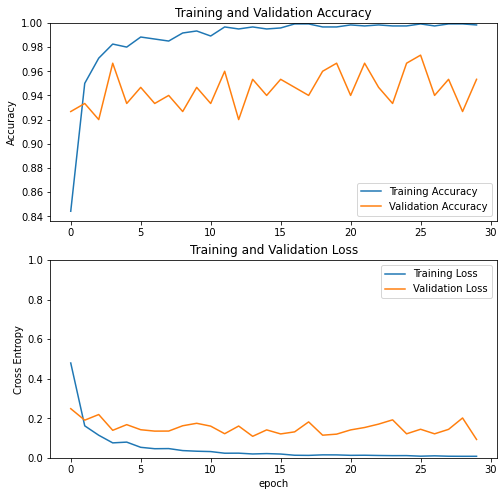

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

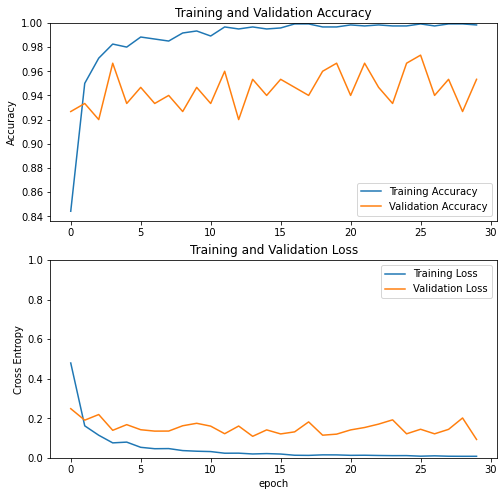

In [99]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [9]:
from io import BytesIO

def preprocess(img):
    nimg = img.convert('RGB').resize(dim, resample= 0)
    img_arr = (np.array(nimg,dtype=np.float32))/255
    img_arr = img_arr.reshape(1, dim[0], dim[1], channel[0])
    return img_arr

def get_imgs(path):
    if os.path.exists(path):
        im = PIL.Image.open(path)
    else:
        im = Image.open(BytesIO(requests.get(path).content))
        
    im_arr = preprocess(im)
    return im_arr

In [10]:
# make predict
def scan_dir(path):
    file_name = []
    folder_name = []
    full_path = []
    for path, subdirs, files in os.walk(mypath):
        for name in files:
            full_path.append(os.path.join(path, name)) 
            folder_name.append(path.split('/')[-1].lower())        
            file_name.append(name)
    return full_path, folder_name , file_name

In [11]:
def tflite_predict(X):
    interpreter.set_tensor(input_details[0]['index'], X)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    return output_data

In [12]:
mypath= 'data/test/'

full_path,tag,file_name = scan_dir(mypath)

# memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"label":tag})
df.groupby(['label']).size()

label
bathroom    30
bedroom     30
exterior    30
food        30
gym         30
dtype: int64

In [13]:
df

,path,file_name,label
0,data/test/food/food_131.png,food_131.png,food
1,data/test/food/food_126.png,food_126.png,food
2,data/test/food/food_267.png,food_267.png,food
3,data/test/food/food_120.png,food_120.png,food
4,data/test/food/food_138.png,food_138.png,food
...,...,...,...
145,data/test/bedroom/bedroom_86.png,bedroom_86.png,bedroom
146,data/test/bedroom/bedroom_16.png,bedroom_16.png,bedroom
147,data/test/bedroom/bedroom_291.png,bedroom_291.png,bedroom
148,data/test/bedroom/bedroom_138.png,bedroom_138.png,bedroom


#Tflite convert

In [47]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_fp16_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmppjukrjoh/assets


INFO:tensorflow:Assets written to: /tmp/tmppjukrjoh/assets


In [65]:
%%time

detected_label = []
predicted_label_prob = []
predicted_proba = []

for index, row in tqdm(df.iterrows(),total=len(df)):
    try:
        url = row['path']
        X = get_imgs(url)
#         y = tflite_predict(X)
        y = model.predict(X)
        y_prob = np.max(y)

        detected_label.append([*labels][np.argmax(y)])
        predicted_label_prob.append(y_prob)
        predicted_proba.append(y)
    
    except:
        detected_label.append('Fail')
        predicted_label_prob.append(0)
        predicted_proba.append(None)
        
df['predicted_label'] = detected_label
df['predicted_label_prob'] = predicted_label_prob
df['predicted_proba'] = predicted_proba


100%|██████████| 150/150 [00:23<00:00,  6.27it/s]

CPU times: user 27.8 s, sys: 2.76 s, total: 30.6 s
Wall time: 23.9 s


In [58]:
df

,path,file_name,label,predicted_label,predicted_label_prob,predicted_proba
0,data/test/food/food_131.png,food_131.png,food,food,0.998569,"[[0.0002469795, 0.0006723139, 0.00014755923, 0..."
1,data/test/food/food_126.png,food_126.png,food,food,0.999957,"[[7.7033974e-07, 2.8929622e-05, 1.18934095e-05..."
2,data/test/food/food_267.png,food_267.png,food,food,1.000000,"[[2.0597318e-08, 3.5929297e-09, 7.867917e-08, ..."
3,data/test/food/food_120.png,food_120.png,food,food,0.999994,"[[1.2472881e-06, 5.2410945e-07, 2.2539616e-06,..."
4,data/test/food/food_138.png,food_138.png,food,food,0.999999,"[[3.596144e-08, 6.831858e-09, 9.0394076e-07, 0..."
...,...,...,...,...,...,...
145,data/test/bedroom/bedroom_86.png,bedroom_86.png,bedroom,bedroom,0.999983,"[[1.1658859e-06, 0.9999827, 9.2534655e-08, 1.2..."
146,data/test/bedroom/bedroom_16.png,bedroom_16.png,bedroom,bedroom,0.999982,"[[2.7910469e-06, 0.9999821, 4.5618044e-08, 2.2..."
147,data/test/bedroom/bedroom_291.png,bedroom_291.png,bedroom,bedroom,0.999998,"[[8.390228e-08, 0.99999845, 6.7691532e-09, 1.2..."
148,data/test/bedroom/bedroom_138.png,bedroom_138.png,bedroom,bedroom,0.999828,"[[4.3699252e-05, 0.9998282, 3.6782984e-07, 6.2..."


In [66]:
from sklearn.metrics import confusion_matrix, classification_report,plot_confusion_matrix,confusion_matrix

df_t = df[df['predicted_label']!='Fail']
print("=========================Test Data==============================")
print(classification_report(df_t['label'],df_t['predicted_label'],digits=3))
print("=================================================================")
arr_ = confusion_matrix(df_t['label'],df_t['predicted_label'])
print(arr_ )

=========================Test Data==============================
              precision    recall  f1-score   support

    bathroom      1.000     0.900     0.947        30
     bedroom      1.000     0.967     0.983        30
    exterior      0.938     1.000     0.968        30
        food      0.968     1.000     0.984        30
         gym      0.935     0.967     0.951        30

    accuracy                          0.967       150
   macro avg      0.968     0.967     0.967       150
weighted avg      0.968     0.967     0.967       150

[[27  0  1  1  1]
 [ 0 29  0  0  1]
 [ 0  0 30  0  0]
 [ 0  0  0 30  0]
 [ 0  0  1  0 29]]


In [64]:
df_cm = pd.DataFrame(arr_, index = [i for i in [*labels]],
                  columns = [i for i in [*labels]])
df_cm

,bathroom,bedroom,exterior,food,gym
bathroom,27,0,1,1,1
bedroom,0,29,0,0,1
exterior,0,0,30,0,0
food,0,0,0,30,0
gym,0,0,1,0,29


# error analysis

In [77]:
err = df[df['predicted_label']!=df['label']].reset_index(drop=True)
err

,path,file_name,label,predicted_label,predicted_label_prob,predicted_proba
0,data/test/bathroom/bath_247.png,bath_247.png,bathroom,food,0.955728,"[[0.04325453, 0.00017857045, 0.0004498432, 0.9..."
1,data/test/bathroom/bath_138.png,bath_138.png,bathroom,exterior,0.834278,"[[0.09835361, 0.0010072546, 0.83427775, 0.0044..."
2,data/test/bathroom/bath_294.png,bath_294.png,bathroom,gym,0.829568,"[[0.09823238, 8.061955e-06, 0.07198587, 0.0002..."
3,data/test/gym/gym_155.png,gym_155.png,gym,exterior,0.999033,"[[0.00025677346, 1.952095e-07, 0.999033, 0.000..."
4,data/test/bedroom/bedroom_12.png,bedroom_12.png,bedroom,gym,0.997694,"[[0.0009876483, 0.0012395814, 6.567962e-05, 1...."


<PIL.Image.Image image mode=RGB size=224x224 at 0x7F95E1FA0A90>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F95A2711340>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F95A25EA370>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F95A25EA3D0>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F95A25EA880>


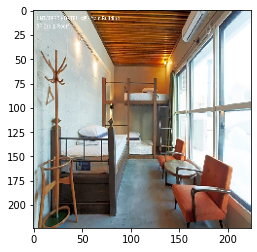

In [80]:
for i in range(len(err)):
    img = image.load_img(err['path'].loc[i],target_size=dim)
    print(img)
    plt.imshow(img)

In [82]:
err

,path,file_name,label,predicted_label,predicted_label_prob,predicted_proba
0,data/test/bathroom/bath_247.png,bath_247.png,bathroom,food,0.955728,"[[0.04325453, 0.00017857045, 0.0004498432, 0.9..."
1,data/test/bathroom/bath_138.png,bath_138.png,bathroom,exterior,0.834278,"[[0.09835361, 0.0010072546, 0.83427775, 0.0044..."
2,data/test/bathroom/bath_294.png,bath_294.png,bathroom,gym,0.829568,"[[0.09823238, 8.061955e-06, 0.07198587, 0.0002..."
3,data/test/gym/gym_155.png,gym_155.png,gym,exterior,0.999033,"[[0.00025677346, 1.952095e-07, 0.999033, 0.000..."
4,data/test/bedroom/bedroom_12.png,bedroom_12.png,bedroom,gym,0.997694,"[[0.0009876483, 0.0012395814, 6.567962e-05, 1...."


<PIL.Image.Image image mode=RGB size=224x224 at 0x7F95A20EA490>


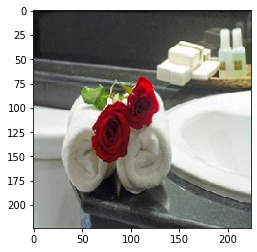

In [201]:
img = image.load_img(err['path'].loc[0],target_size=dim)
print(img)
plt.imshow(img)

In [177]:
labels

{'bathroom': 0, 'bedroom': 1, 'exterior': 2, 'food': 3, 'gym': 4}

In [87]:
err['predicted_proba'].loc[4]

array([[9.8764827e-04, 1.2395814e-03, 6.5679618e-05, 1.3139757e-05,
        9.9769396e-01]], dtype=float32)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F957E3EC520>


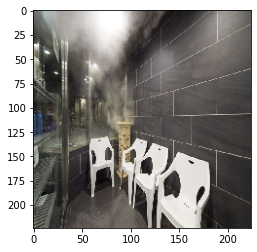

In [242]:
img = image.load_img(err['path'].loc[1],target_size=dim)
print(img)
plt.imshow(img)

In [243]:
err['predicted_proba'].loc[1]

array([[0.09835361, 0.00100725, 0.83427775, 0.0044827 , 0.06187867]],
      dtype=float32)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F95A180C400>


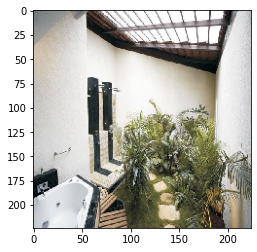

In [244]:
img = image.load_img(err['path'].loc[2],target_size=dim)
print(img)
plt.imshow(img)

In [245]:
err['predicted_proba'].loc[2]

array([[9.8232381e-02, 8.0619548e-06, 7.1985871e-02, 2.0607244e-04,
        8.2956767e-01]], dtype=float32)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F95A18729A0>


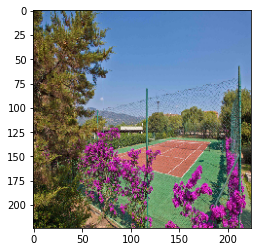

In [246]:
img = image.load_img(err['path'].loc[3],target_size=dim)
print(img)
plt.imshow(img)

In [247]:
err['predicted_proba'].loc[3]

array([[2.5677346e-04, 1.9520949e-07, 9.9903297e-01, 7.0869003e-04,
        1.3558032e-06]], dtype=float32)

# Reduce overvfit in Model

In [212]:
from tensorflow.keras import layers,Sequential
#Adding custom layers 
x2 = base_model.output
x2 = layers.GlobalAveragePooling2D()(x2)
x2 = layers.Dropout(0.5)(x2)
predictions = layers.Dense(num_class, activation="softmax")(x2)

model2 = Model(inputs = base_model.input, outputs = predictions)

In [213]:
#compiling model
print('Compiling Model...') 
LR = 0.001
model2.compile(
    optimizer=Adam(learning_rate=LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Compiling Model...


In [214]:
model2.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [215]:
EPOCH = 30
history2 = model2.fit(train_data,
        steps_per_epoch= len(train_generator), 
        epochs=EPOCH,
        validation_data=val_data,
        validation_steps= len(val_generator),
        shuffle=True,
        verbose = 1)

Epoch 1/30
120/120 [==============================] - 184s 1s/step - loss: 0.7216 - accuracy: 0.7417 - val_loss: 0.2716 - val_accuracy: 0.9067
Epoch 2/30
120/120 [==============================] - 176s 1s/step - loss: 0.2655 - accuracy: 0.9150 - val_loss: 0.1839 - val_accuracy: 0.9467
Epoch 3/30
120/120 [==============================] - 177s 1s/step - loss: 0.1908 - accuracy: 0.9333 - val_loss: 0.1466 - val_accuracy: 0.9400
Epoch 4/30
120/120 [==============================] - 175s 1s/step - loss: 0.1728 - accuracy: 0.9367 - val_loss: 0.1706 - val_accuracy: 0.9200
Epoch 5/30
120/120 [==============================] - 174s 1s/step - loss: 0.1449 - accuracy: 0.9542 - val_loss: 0.1470 - val_accuracy: 0.9467
Epoch 6/30
120/120 [==============================] - 171s 1s/step - loss: 0.1209 - accuracy: 0.9642 - val_loss: 0.1221 - val_accuracy: 0.9467
Epoch 7/30
120/120 [==============================] - 177s 1s/step - loss: 0.1120 - accuracy: 0.9642 - val_loss: 0.1611 - val_accuracy: 0.9267

In [137]:
model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [216]:
# save moedel
MODEL_BASE_PATH ='model/'

save_model_path = os.path.join(MODEL_BASE_PATH, "mobile_v2_2_reduce.h5")

model2.save(save_model_path, include_optimizer=False, save_format='h5')

In [27]:
def ploting(acc_tr,acc_val, loss_tr, loss_val):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc_tr, label='Training Accuracy')
    plt.plot(acc_val, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss_tr, label='Training Loss')
    plt.plot(loss_val, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

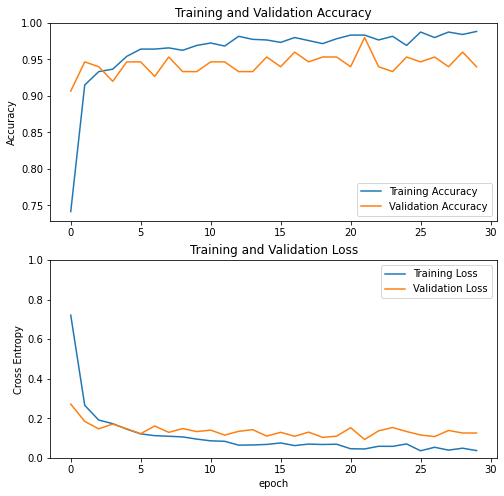

In [217]:
#update reduce without callback
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

ploting(acc2,val_acc2,loss2,val_loss2)

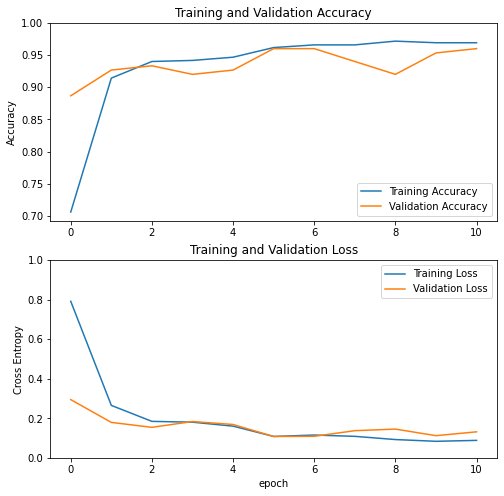

In [209]:
#update reduce with callback
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

ploting(acc2,val_acc2,loss2,val_loss2)

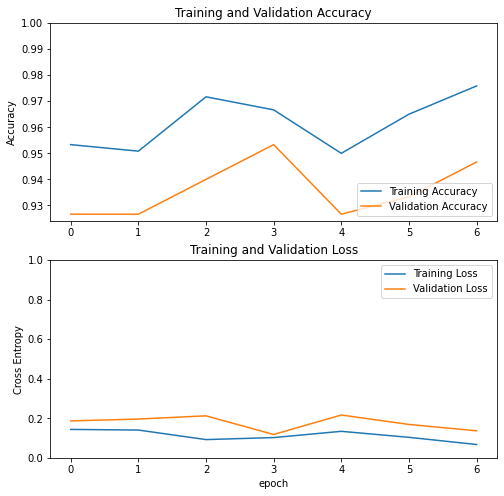

In [107]:
#old
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

ploting(acc2,val_acc2,loss2,val_loss2)

In [218]:
%%time

detected_label2 = []
predicted_label_prob2 = []
predicted_proba2 = []

for index, row in tqdm(df.iterrows(),total=len(df)):
    try:
        url = row['path']
        X = get_imgs(url)
        y = model2.predict(X)
        y_prob = np.max(y)

        detected_label2.append([*labels][np.argmax(y)])
        predicted_label_prob2.append(y_prob)
        predicted_proba2.append(y)
    
    except:
        detected_label2.append('Fail')
        predicted_label_prob2.append(0)
        predicted_proba2.append(None)
        
df['predicted_label2'] = detected_label2
df['predicted_label_prob2'] = predicted_label_prob2
df['predicted_proba2'] = predicted_proba2

100%|██████████| 150/150 [00:32<00:00,  4.57it/s]


CPU times: user 30 s, sys: 2.55 s, total: 32.6 s
Wall time: 32.9 s


In [109]:
df

,path,file_name,label,predicted_label,predicted_label_prob,predicted_proba,predicted_label2,predicted_label_prob2,predicted_proba2
0,data/test/food/food_131.png,food_131.png,food,food,0.998569,"[[0.0002469795, 0.0006723139, 0.00014755923, 0...",food,0.999342,"[[0.0005502062, 1.4205568e-05, 1.4502168e-05, ..."
1,data/test/food/food_126.png,food_126.png,food,food,0.999957,"[[7.7033974e-07, 2.8929622e-05, 1.18934095e-05...",food,0.999959,"[[2.0663627e-05, 1.42561275e-05, 2.4911462e-06..."
2,data/test/food/food_267.png,food_267.png,food,food,1.000000,"[[2.0597318e-08, 3.5929297e-09, 7.867917e-08, ...",food,1.000000,"[[1.4252524e-08, 3.9340635e-11, 5.069763e-09, ..."
3,data/test/food/food_120.png,food_120.png,food,food,0.999994,"[[1.2472881e-06, 5.2410945e-07, 2.2539616e-06,...",food,0.999994,"[[5.1015763e-06, 1.7101785e-08, 5.0535715e-07,..."
4,data/test/food/food_138.png,food_138.png,food,food,0.999999,"[[3.596144e-08, 6.831858e-09, 9.0394076e-07, 0...",food,1.000000,"[[4.941695e-10, 9.913998e-14, 2.6833025e-09, 1..."
...,...,...,...,...,...,...,...,...,...
145,data/test/bedroom/bedroom_86.png,bedroom_86.png,bedroom,bedroom,0.999983,"[[1.1658859e-06, 0.9999827, 9.2534655e-08, 1.2...",bedroom,0.999985,"[[2.658356e-06, 0.999985, 6.9204984e-09, 7.690..."
146,data/test/bedroom/bedroom_16.png,bedroom_16.png,bedroom,bedroom,0.999982,"[[2.7910469e-06, 0.9999821, 4.5618044e-08, 2.2...",bedroom,0.999991,"[[4.584284e-06, 0.99999094, 9.317271e-10, 3.27..."
147,data/test/bedroom/bedroom_291.png,bedroom_291.png,bedroom,bedroom,0.999998,"[[8.390228e-08, 0.99999845, 6.7691532e-09, 1.2...",bedroom,0.999999,"[[3.2366532e-07, 0.99999905, 3.1623015e-10, 9...."
148,data/test/bedroom/bedroom_138.png,bedroom_138.png,bedroom,bedroom,0.999828,"[[4.3699252e-05, 0.9998282, 3.6782984e-07, 6.2...",bedroom,0.999633,"[[4.093165e-05, 0.9996331, 1.3851051e-08, 6.78..."


In [219]:
#update w/o call back
from sklearn.metrics import confusion_matrix, classification_report,plot_confusion_matrix,confusion_matrix

df_t = df[df['predicted_label2']!='Fail']
print("=========================Test Data==============================")
print(classification_report(df_t['label'],df_t['predicted_label2'],digits=3))
print("=================================================================")
arr2_ = confusion_matrix(df_t['label'],df_t['predicted_label2'])
print(arr2_ )

=========================Test Data==============================
              precision    recall  f1-score   support

    bathroom      1.000     0.867     0.929        30
     bedroom      0.967     0.967     0.967        30
    exterior      0.938     1.000     0.968        30
        food      0.968     1.000     0.984        30
         gym      0.935     0.967     0.951        30

    accuracy                          0.960       150
   macro avg      0.961     0.960     0.959       150
weighted avg      0.961     0.960     0.959       150

[[26  1  1  1  1]
 [ 0 29  0  0  1]
 [ 0  0 30  0  0]
 [ 0  0  0 30  0]
 [ 0  0  1  0 29]]


In [211]:
#update with callback
from sklearn.metrics import confusion_matrix, classification_report,plot_confusion_matrix,confusion_matrix

df_t = df[df['predicted_label2']!='Fail']
print("=========================Test Data==============================")
print(classification_report(df_t['label'],df_t['predicted_label2'],digits=3))
print("=================================================================")
arr2_ = confusion_matrix(df_t['label'],df_t['predicted_label2'])
print(arr2_ )

=========================Test Data==============================
              precision    recall  f1-score   support

    bathroom      1.000     0.867     0.929        30
     bedroom      0.966     0.933     0.949        30
    exterior      0.938     1.000     0.968        30
        food      0.909     1.000     0.952        30
         gym      0.933     0.933     0.933        30

    accuracy                          0.947       150
   macro avg      0.949     0.947     0.946       150
weighted avg      0.949     0.947     0.946       150

[[26  1  1  1  1]
 [ 0 28  0  1  1]
 [ 0  0 30  0  0]
 [ 0  0  0 30  0]
 [ 0  0  1  1 28]]


In [224]:
from tensorflow import keras
model2_1 = keras.models.load_model('model/mobile_v2_1.h5')

In [225]:
model2_1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

# FIne tuning

In [190]:
base_model.trainable = False

In [151]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [164]:
len(model.trainable_variables)

56

In [161]:
#compiling model
print('Compiling Model...') 
LR = 0.001
model.compile(
    optimizer=Adam(learning_rate=LR/10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Compiling Model...


In [162]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
fine_tune_epochs =10

In [165]:
EPOCH = 30
history_fine = model.fit(train_data,
        steps_per_epoch= len(train_generator), 
        epochs=EPOCH+fine_tune_epochs,
        initial_epoch=history.epoch[-1],
        validation_data=val_data,
        validation_steps= len(val_generator),
        shuffle=True,
        verbose = 1)

Epoch 30/40
120/120 [==============================] - 202s 2s/step - loss: 0.4018 - accuracy: 0.8875 - val_loss: 0.3825 - val_accuracy: 0.9067
Epoch 31/40
120/120 [==============================] - 184s 2s/step - loss: 0.1253 - accuracy: 0.9600 - val_loss: 0.3744 - val_accuracy: 0.9000
Epoch 32/40
120/120 [==============================] - 170s 1s/step - loss: 0.1448 - accuracy: 0.9483 - val_loss: 0.4471 - val_accuracy: 0.8933
Epoch 33/40
120/120 [==============================] - 175s 1s/step - loss: 0.0769 - accuracy: 0.9717 - val_loss: 0.4826 - val_accuracy: 0.8667
Epoch 34/40
120/120 [==============================] - 175s 1s/step - loss: 0.0895 - accuracy: 0.9642 - val_loss: 0.4189 - val_accuracy: 0.8933
Epoch 35/40
120/120 [==============================] - 183s 2s/step - loss: 0.0601 - accuracy: 0.9833 - val_loss: 0.7389 - val_accuracy: 0.8267
Epoch 36/40
120/120 [==============================] - 182s 2s/step - loss: 0.0703 - accuracy: 0.9775 - val_loss: 0.5037 - val_accuracy:

In [170]:
initial_epochs=30

In [166]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

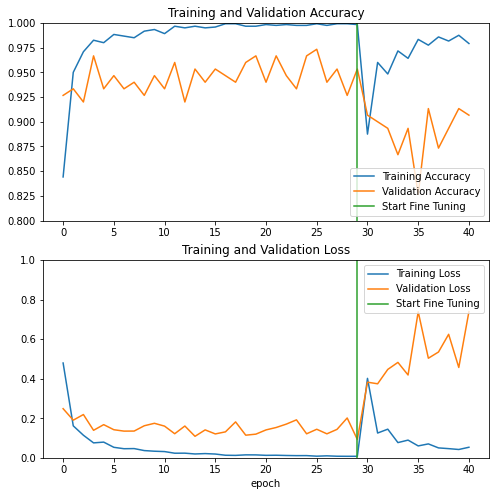

In [171]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

In [172]:
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=1)
print("Test model on testing dataset")
print('Model Loss {:.4f}'.format(loss))
print('Model Acc {:.4f}'.format(acc))

15/15 [==============================] - 19s 1s/step - loss: 0.5415 - accuracy: 0.9133
Test model on testing dataset
Model Loss 0.5415
Model Acc 0.9133


In [40]:
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=1)
print("Test model on testing dataset")
print('Model Loss {:.4f}'.format(loss))
print('Model Acc {:.4f}'.format(acc))

15/15 [==============================] - 14s 926ms/step - loss: 0.1642 - accuracy: 0.9467
Test model on testing dataset
Model Loss 0.1642
Model Acc 0.9467


In [173]:
detected_label_tun = []
predicted_label_prob_tun = []
predicted_proba_tun = []

for index, row in tqdm(df.iterrows(),total=len(df)):
    try:
        url = row['path']
        X = get_imgs(url)
        y = model.predict(X)
        y_prob = np.max(y)

        detected_label_tun.append([*labels][np.argmax(y)])
        predicted_label_prob_tun.append(y_prob)
        predicted_proba_tun.append(y)
    
    except:
        detected_label_tun.append('Fail')
        predicted_label_prob_tun.append(0)
        predicted_proba_tun.append(None)
        
df['predicted_label_tun'] = detected_label_tun
df['predicted_label_prob_tun'] = predicted_label_prob_tun
df['predicted_proba_tun'] = predicted_proba_tun

100%|██████████| 150/150 [00:27<00:00,  5.37it/s]


In [174]:
from sklearn.metrics import confusion_matrix, classification_report,plot_confusion_matrix,confusion_matrix

df_t = df[df['predicted_label_tun']!='Fail']
print("=========================Test Data==============================")
print(classification_report(df_t['label'],df_t['predicted_label_tun'],digits=3))
print("=================================================================")
arr_tun = confusion_matrix(df_t['label'],df_t['predicted_label_tun'])
print(arr_tun )

=========================Test Data==============================
              precision    recall  f1-score   support

    bathroom      0.966     0.933     0.949        30
     bedroom      1.000     1.000     1.000        30
    exterior      0.811     1.000     0.896        30
        food      0.966     0.933     0.949        30
         gym      1.000     0.833     0.909        30

    accuracy                          0.940       150
   macro avg      0.948     0.940     0.941       150
weighted avg      0.948     0.940     0.941       150

[[28  0  1  1  0]
 [ 0 30  0  0  0]
 [ 0  0 30  0  0]
 [ 0  0  2 28  0]
 [ 1  0  4  0 25]]


In [66]:
#BEfore finetune
from sklearn.metrics import confusion_matrix, classification_report,plot_confusion_matrix,confusion_matrix

df_t = df[df['predicted_label']!='Fail']
print("=========================Test Data==============================")
print(classification_report(df_t['label'],df_t['predicted_label'],digits=3))
print("=================================================================")
arr_ = confusion_matrix(df_t['label'],df_t['predicted_label'])
print(arr_ )

=========================Test Data==============================
              precision    recall  f1-score   support

    bathroom      1.000     0.900     0.947        30
     bedroom      1.000     0.967     0.983        30
    exterior      0.938     1.000     0.968        30
        food      0.968     1.000     0.984        30
         gym      0.935     0.967     0.951        30

    accuracy                          0.967       150
   macro avg      0.968     0.967     0.967       150
weighted avg      0.968     0.967     0.967       150

[[27  0  1  1  1]
 [ 0 29  0  0  1]
 [ 0  0 30  0  0]
 [ 0  0  0 30  0]
 [ 0  0  1  0 29]]


In [219]:
#update w/o call back
from sklearn.metrics import confusion_matrix, classification_report,plot_confusion_matrix,confusion_matrix

df_t = df[df['predicted_label2']!='Fail']
print("=========================Test Data==============================")
print(classification_report(df_t['label'],df_t['predicted_label2'],digits=3))
print("=================================================================")
arr2_ = confusion_matrix(df_t['label'],df_t['predicted_label2'])
print(arr2_ )

=========================Test Data==============================
              precision    recall  f1-score   support

    bathroom      1.000     0.867     0.929        30
     bedroom      0.967     0.967     0.967        30
    exterior      0.938     1.000     0.968        30
        food      0.968     1.000     0.984        30
         gym      0.935     0.967     0.951        30

    accuracy                          0.960       150
   macro avg      0.961     0.960     0.959       150
weighted avg      0.961     0.960     0.959       150

[[26  1  1  1  1]
 [ 0 29  0  0  1]
 [ 0  0 30  0  0]
 [ 0  0  0 30  0]
 [ 0  0  1  0 29]]


In [111]:
# adding some layer
from sklearn.metrics import confusion_matrix, classification_report,plot_confusion_matrix,confusion_matrix

df_t = df[df['predicted_label2']!='Fail']
print("=========================Test Data==============================")
print(classification_report(df_t['label'],df_t['predicted_label2'],digits=3))
print("=================================================================")
arr2_ = confusion_matrix(df_t['label'],df_t['predicted_label2'])
print(arr2_ )

=========================Test Data==============================
              precision    recall  f1-score   support

    bathroom      1.000     0.833     0.909        30
     bedroom      0.966     0.933     0.949        30
    exterior      0.909     1.000     0.952        30
        food      0.882     1.000     0.938        30
         gym      0.966     0.933     0.949        30

    accuracy                          0.940       150
   macro avg      0.944     0.940     0.939       150
weighted avg      0.944     0.940     0.939       150

[[25  1  2  2  0]
 [ 0 28  0  1  1]
 [ 0  0 30  0  0]
 [ 0  0  0 30  0]
 [ 0  0  1  1 28]]


# Try aother

In [233]:
from tensorflow.keras import layers,Sequential
#Adding custom layers 
x2 = base_model.output
x2 = layers.GlobalAveragePooling2D()(x2)
x2 = layers.Dropout(0.5)(x2)
x2 = layers.Dense(64, activation="relu")(x2)
predictions = layers.Dense(num_class, activation="softmax")(x2)

model3 = Model(inputs = base_model.input, outputs = predictions)

In [234]:
#compiling model
print('Compiling Model...') 
LR = 0.001
model3.compile(
    optimizer=Adam(learning_rate=LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Compiling Model...


In [235]:
model3.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                          

In [238]:
EPOCH = 30
history3 = model3.fit(train_data,
        steps_per_epoch= len(train_generator), 
        epochs=EPOCH,
        validation_data=val_data,
        validation_steps= len(val_generator),
        callbacks= earlystop_callback,
        shuffle=True,
        verbose = 1)

Epoch 1/30
120/120 [==============================] - 188s 2s/step - loss: 0.5227 - accuracy: 0.8183 - val_loss: 0.2111 - val_accuracy: 0.9133
Epoch 2/30
120/120 [==============================] - 175s 1s/step - loss: 0.2519 - accuracy: 0.9242 - val_loss: 0.1804 - val_accuracy: 0.9333
Epoch 3/30
120/120 [==============================] - 173s 1s/step - loss: 0.1758 - accuracy: 0.9367 - val_loss: 0.1654 - val_accuracy: 0.9267
Epoch 4/30
120/120 [==============================] - 171s 1s/step - loss: 0.0926 - accuracy: 0.9692 - val_loss: 0.0999 - val_accuracy: 0.9600
Epoch 5/30
120/120 [==============================] - 174s 1s/step - loss: 0.0940 - accuracy: 0.9642 - val_loss: 0.1310 - val_accuracy: 0.9467
Epoch 6/30
120/120 [==============================] - 172s 1s/step - loss: 0.1116 - accuracy: 0.9692 - val_loss: 0.2482 - val_accuracy: 0.9200
Epoch 7/30
120/120 [==============================] - 174s 1s/step - loss: 0.1037 - accuracy: 0.9733 - val_loss: 0.1856 - val_accuracy: 0.9333

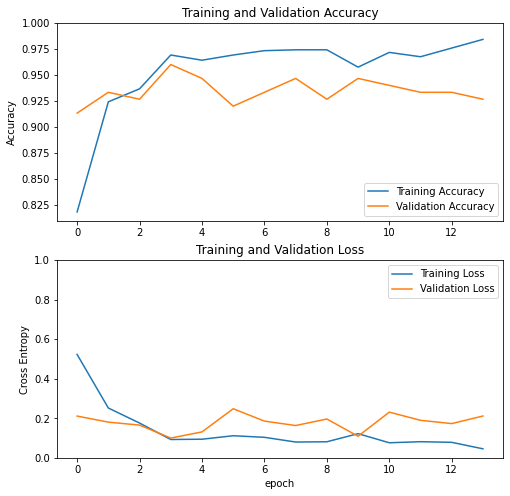

In [239]:
#update reduce without callback
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']

loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

ploting(acc3,val_acc3,loss3,val_loss3)

In [267]:
import PIL.Image 

In [268]:
detected_label3 = []
predicted_label_prob3 = []
predicted_proba3 = []

for index, row in tqdm(df.iterrows(),total=len(df)):
#     try:
        url = row['path']
        X = get_imgs(url)
        y = model3.predict(X)
        y_prob = np.max(y)

        detected_label3.append([*labels][np.argmax(y)])
        predicted_label_prob3.append(y_prob)
        predicted_proba3.append(y)
    
#     except:
#         detected_label3.append('Fail')
#         predicted_label_prob3.append(0)
#         predicted_proba3.append(None)
        
df['predicted_label3'] = detected_label3
df['predicted_label_prob3'] = predicted_label_prob3
df['predicted_proba3'] = predicted_proba3

100%|██████████| 150/150 [00:33<00:00,  4.50it/s]


In [269]:
from sklearn.metrics import confusion_matrix, classification_report,plot_confusion_matrix,confusion_matrix

df_3 = df[df['predicted_label3']!='Fail']
print("=========================Test Data==============================")
print(classification_report(df_3['label'],df_3['predicted_label3'],digits=3))
print("=================================================================")
arr_3= confusion_matrix(df_3['label'],df_3['predicted_label3'])
print(arr_3)

=========================Test Data==============================
              precision    recall  f1-score   support

    bathroom      1.000     0.933     0.966        30
     bedroom      1.000     0.933     0.966        30
    exterior      0.938     1.000     0.968        30
        food      0.968     1.000     0.984        30
         gym      0.935     0.967     0.951        30

    accuracy                          0.967       150
   macro avg      0.968     0.967     0.967       150
weighted avg      0.968     0.967     0.967       150

[[28  0  1  1  0]
 [ 0 28  0  0  2]
 [ 0  0 30  0  0]
 [ 0  0  0 30  0]
 [ 0  0  1  0 29]]


In [66]:
#BEfore finetune
from sklearn.metrics import confusion_matrix, classification_report,plot_confusion_matrix,confusion_matrix

df_t = df[df['predicted_label']!='Fail']
print("=========================Test Data==============================")
print(classification_report(df_t['label'],df_t['predicted_label'],digits=3))
print("=================================================================")
arr_ = confusion_matrix(df_t['label'],df_t['predicted_label'])
print(arr_ )

=========================Test Data==============================
              precision    recall  f1-score   support

    bathroom      1.000     0.900     0.947        30
     bedroom      1.000     0.967     0.983        30
    exterior      0.938     1.000     0.968        30
        food      0.968     1.000     0.984        30
         gym      0.935     0.967     0.951        30

    accuracy                          0.967       150
   macro avg      0.968     0.967     0.967       150
weighted avg      0.968     0.967     0.967       150

[[27  0  1  1  1]
 [ 0 29  0  0  1]
 [ 0  0 30  0  0]
 [ 0  0  0 30  0]
 [ 0  0  1  0 29]]


## err analy 2

In [272]:
err2 = df[df['predicted_label3']!=df['label']].reset_index(drop=True)
err2

,path,file_name,label,predicted_label,predicted_label_prob,predicted_proba,predicted_label2,predicted_label_prob2,predicted_proba2,predicted_label3,predicted_label_prob3,predicted_proba3,predicted_label_tun,predicted_label_prob_tun,predicted_proba_tun
0,data/test/bathroom/bath_247.png,bath_247.png,bathroom,food,0.955728,"[[0.04325453, 0.00017857045, 0.0004498432, 0.9...",food,0.892303,"[[0.102640755, 0.0026877513, 0.00074975094, 0....",food,0.775727,"[[0.21930699, 0.00077693735, 0.0016359533, 0.7...",food,0.900298,"[[0.001957862, 0.001525935, 0.09621786, 0.9002..."
1,data/test/bathroom/bath_138.png,bath_138.png,bathroom,exterior,0.834278,"[[0.09835361, 0.0010072546, 0.83427775, 0.0044...",exterior,0.456182,"[[0.32966015, 0.00083042413, 0.4561822, 0.0012...",exterior,0.929507,"[[0.018876163, 0.00092766085, 0.92950684, 0.00...",bathroom,0.520630,"[[0.52063, 8.510596e-07, 0.47936848, 4.785699e..."
2,data/test/gym/gym_155.png,gym_155.png,gym,exterior,0.999033,"[[0.00025677346, 1.952095e-07, 0.999033, 0.000...",exterior,0.999130,"[[7.223593e-05, 7.6163815e-07, 0.9991297, 0.00...",exterior,0.994604,"[[0.0042091883, 6.464418e-06, 0.9946037, 0.001...",exterior,0.998882,"[[1.0301623e-06, 5.2638696e-12, 0.998882, 0.00..."
3,data/test/bedroom/bedroom_12.png,bedroom_12.png,bedroom,gym,0.997694,"[[0.0009876483, 0.0012395814, 6.567962e-05, 1....",gym,0.998716,"[[2.5227613e-05, 0.0012525109, 3.3683139e-06, ...",gym,0.952157,"[[0.0017438012, 0.045250565, 0.00047549617, 0....",bedroom,0.542277,"[[0.19619477, 0.5422767, 0.07422874, 1.0019587..."
4,data/test/bedroom/bedroom_20.png,bedroom_20.png,bedroom,bedroom,0.565940,"[[0.009162521, 0.5659403, 8.696436e-05, 0.0002...",bedroom,0.605604,"[[0.01916129, 0.60560364, 2.8357093e-05, 0.000...",gym,0.535019,"[[0.09500739, 0.36505774, 0.0014484748, 0.0034...",bedroom,0.999197,"[[5.42209e-10, 0.9991968, 6.6519795e-05, 2.040..."


<PIL.Image.Image image mode=RGB size=224x224 at 0x7F95990B6790>


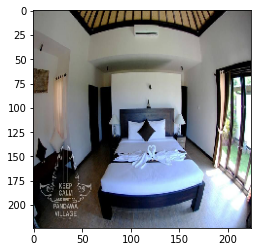

In [282]:
img = image.load_img(err2['path'].loc[4],target_size=dim)
print(img)
plt.imshow(img)

In [280]:
err2['predicted_proba'].loc[4]

array([[9.1625210e-03, 5.6594032e-01, 8.6964363e-05, 2.1817391e-04,
        4.2459199e-01]], dtype=float32)

# BAse V2

In [18]:
base_model = MobileNetV2(
          input_shape=input_shape, 
          include_top=False, 
          weights= 'imagenet')


base_model.trainable=False

In [23]:
x = base_model.output
x =  tf.keras.layers.GlobalAveragePooling2D()(x)
predictions =  tf.keras.layers.Dense(num_class, activation="softmax")(x)

model_v2 = Model(inputs = base_model.input, outputs = predictions)



In [24]:
#compiling model
print('Compiling Model...') 
LR = 0.0001
model_v2.compile(
    optimizer=Adam(learning_rate=LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Compiling Model...


In [25]:
EPOCH = 30
history_v2 = model_v2.fit(train_data,
        steps_per_epoch= len(train_generator), 
        epochs=EPOCH,
        validation_data=val_data,
        validation_steps= len(val_generator),
        shuffle=True,
        verbose = 1)

Epoch 1/30
120/120 [==============================] - 184s 1s/step - loss: 1.4190 - accuracy: 0.4242 - val_loss: 0.9984 - val_accuracy: 0.6733
Epoch 2/30
120/120 [==============================] - 126s 1s/step - loss: 0.8133 - accuracy: 0.7717 - val_loss: 0.6428 - val_accuracy: 0.8400
Epoch 3/30
120/120 [==============================] - 126s 1s/step - loss: 0.5309 - accuracy: 0.8817 - val_loss: 0.4822 - val_accuracy: 0.8667
Epoch 4/30
120/120 [==============================] - 126s 1s/step - loss: 0.4131 - accuracy: 0.9017 - val_loss: 0.3587 - val_accuracy: 0.9333
Epoch 5/30
120/120 [==============================] - 126s 1s/step - loss: 0.3265 - accuracy: 0.9425 - val_loss: 0.3319 - val_accuracy: 0.8867
Epoch 6/30
120/120 [==============================] - 125s 1s/step - loss: 0.2755 - accuracy: 0.9492 - val_loss: 0.3013 - val_accuracy: 0.9000
Epoch 7/30
120/120 [==============================] - 126s 1s/step - loss: 0.2419 - accuracy: 0.9517 - val_loss: 0.2826 - val_accuracy: 0.9067

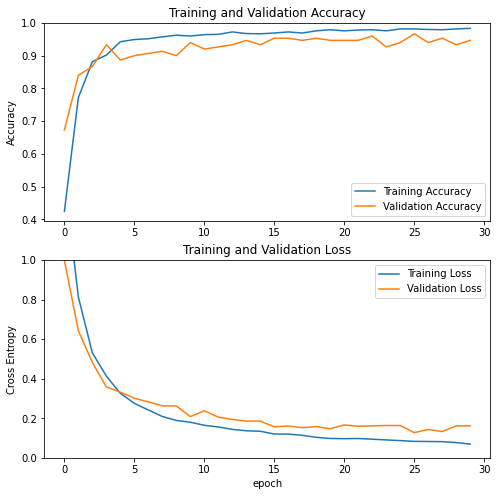

In [28]:
#update reduce without callback
acc3 = history_v2.history['accuracy']
val_acc3 = history_v2.history['val_accuracy']

loss3 = history_v2.history['loss']
val_loss3 = history_v2.history['val_loss']

ploting(acc3,val_acc3,loss3,val_loss3)

In [29]:
import PIL.Image 

In [38]:
detected_label3 = []
predicted_label_prob3 = []
predicted_proba3 = []

for index, row in tqdm(df.iterrows(),total=len(df)):
    try:
        url = row['path']
        X = get_imgs(url)
        y = model_v2.predict(X)
        y_prob = np.max(y)

        detected_label3.append([*labels][np.argmax(y)])
        predicted_label_prob3.append(y_prob)
        predicted_proba3.append(y)
    
    except:
        detected_label3.append('Fail')
        predicted_label_prob3.append(0)
        predicted_proba3.append(None)
        
df['predicted_label_v2'] = detected_label3
df['predicted_label_prob_v2'] = predicted_label_prob3
df['predicted_proba_v2'] = predicted_proba3

100%|██████████| 150/150 [00:24<00:00,  6.07it/s]


In [40]:
from sklearn.metrics import confusion_matrix, classification_report,plot_confusion_matrix,confusion_matrix

df_3 = df[df['predicted_label_v2']!='Fail']
print("=========================Test Data==============================")
print(classification_report(df_3['label'],df_3['predicted_label_v2'],digits=3))
print("=================================================================")
arr_3= confusion_matrix(df_3['label'],df_3['predicted_label_v2'])
print(arr_3)

=========================Test Data==============================
              precision    recall  f1-score   support

    bathroom      1.000     0.900     0.947        30
     bedroom      1.000     0.967     0.983        30
    exterior      0.909     1.000     0.952        30
        food      0.968     1.000     0.984        30
         gym      0.967     0.967     0.967        30

    accuracy                          0.967       150
   macro avg      0.969     0.967     0.967       150
weighted avg      0.969     0.967     0.967       150

[[27  0  2  1  0]
 [ 0 29  0  0  1]
 [ 0  0 30  0  0]
 [ 0  0  0 30  0]
 [ 0  0  1  0 29]]


In [66]:
from sklearn.metrics import confusion_matrix, classification_report,plot_confusion_matrix,confusion_matrix

df_t = df[df['predicted_label']!='Fail']
print("=========================Test Data==============================")
print(classification_report(df_t['label'],df_t['predicted_label'],digits=3))
print("=================================================================")
arr_ = confusion_matrix(df_t['label'],df_t['predicted_label'])
print(arr_ )

=========================Test Data==============================
              precision    recall  f1-score   support

    bathroom      1.000     0.900     0.947        30
     bedroom      1.000     0.967     0.983        30
    exterior      0.938     1.000     0.968        30
        food      0.968     1.000     0.984        30
         gym      0.935     0.967     0.951        30

    accuracy                          0.967       150
   macro avg      0.968     0.967     0.967       150
weighted avg      0.968     0.967     0.967       150

[[27  0  1  1  1]
 [ 0 29  0  0  1]
 [ 0  0 30  0  0]
 [ 0  0  0 30  0]
 [ 0  0  1  0 29]]


In [41]:
# save moedel
MODEL_BASE_PATH ='model/'

save_model_path = os.path.join(MODEL_BASE_PATH, "mobile_base2_v2.h5")

model_v2.save(save_model_path, save_format='h5')


# Grid Tune

In [42]:
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax']
param_grid = dict(optimizer=optimizer)

In [44]:
seed=7
np.random.seed(seed)

In [45]:
base_model = MobileNetV2(
          input_shape=input_shape, 
          include_top=False, 
          weights= 'imagenet')


base_model.trainable=False

In [23]:
x = base_model.output
x =  tf.keras.layers.GlobalAveragePooling2D()(x)
predictions =  tf.keras.layers.Dense(num_class, activation="softmax")(x)

model_v2 = Model(inputs = base_model.input, outputs = predictions)



In [ ]:
#compiling model
print('Compiling Model...') 
LR = 0.0001
model_v2.compile(
    optimizer=SGD(learning_rate=LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FF0F4461650>


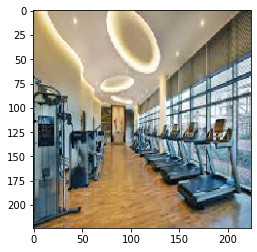

In [38]:
# importing image
filename = 'gym.jpg'
  
#displaying images
# Image(filename,width=224,height=224)
img = image.load_img(filename,target_size=dim)
print(img)
plt.imshow(img)

In [17]:
def prepare_image(file):
    img = image.load_img(file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [27]:
#initializing the model to predict the image details using predefined models.
model = tf.keras.applications.mobilenet_v2.MobileNetV2()
resizedimg = image.img_to_array(img)
finalimg = np.expand_dims(resizedimg,axis=0)
finalimg = tf.keras.applications.mobilenet_v2.preprocess_input(finalimg)
finalimg.shape
predictions = model.predict(finalimg)
  
# To predict and decode the image details
results = imagenet_utils.decode_predictions(predictions)
print(results)

[[('n03661043', 'library', 0.107958704), ('n04005630', 'prison', 0.03481483), ('n04081281', 'restaurant', 0.033404045), ('n02917067', 'bullet_train', 0.029550388), ('n04201297', 'shoji', 0.025856093)]]


In [23]:
gym=prepare_image('gym.jpg')
prd=model.predict(gym)

res=imagenet_utils.decode_predictions(prd)
res

[[('n03661043', 'library', 0.107958704),
  ('n04005630', 'prison', 0.03481483),
  ('n04081281', 'restaurant', 0.033404045),
  ('n02917067', 'bullet_train', 0.029550388),
  ('n04201297', 'shoji', 0.025856093)]]

In [ ]:
def create_dir(path):
    if(not os.path.isdir(path)):
        print('Creating Directory At {}...'.format(path))
        os.mkdir(path)

Setup Data Generator

In [ ]:
# Create Image Generator
def create_new_generator(path, dim, batch_size):
    datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    generator = datagen.flow_from_directory(
        path,
        target_size=dim,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    
    return generator

In [ ]:
def tf_data_generator(generator,dim):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(lambda: generator
    , output_types=(tf.float32, tf.float32)
    , output_shapes = ([None,dim[0],dim[1],3],[None,num_class])                                                 )
    return tf_generator